In [1]:
#### Importing package dependencies
import os, datetime, IPython, IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from utils import WindowGenerator

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False


In [2]:
df = pd.read_csv('hourly.csv',index_col=0)

In [39]:
df

,hour,year,month,day,HOD,DOW,DOY,WOY,QOD,HOW,Number of Patients,Maximum temperature (°C),Minimum temperature (°C)
0,2004-01-01 00:00:00,2004,1,1,0,Thursday,1,1,0.0,73,5,11.4,11.3
1,2004-01-01 01:00:00,2004,1,1,1,Thursday,1,1,0.0,74,11,11.4,11.4
2,2004-01-01 02:00:00,2004,1,1,2,Thursday,1,1,0.0,75,8,10.9,10.8
3,2004-01-01 03:00:00,2004,1,1,3,Thursday,1,1,0.0,76,4,10.7,10.6
4,2004-01-01 04:00:00,2004,1,1,4,Thursday,1,1,0.0,77,5,10.6,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
33596,2007-10-31 20:00:00,2007,10,31,20,Wednesday,304,44,3.0,69,15,22.8,22.8
33597,2007-10-31 21:00:00,2007,10,31,21,Wednesday,304,44,3.0,70,23,22.4,22.3
33598,2007-10-31 22:00:00,2007,10,31,22,Wednesday,304,44,3.0,71,19,22.3,22.2
33599,2007-10-31 23:00:00,2007,10,31,23,Wednesday,304,44,3.0,72,16,22.6,22.5


In [4]:
df.dtypes

hour                         object
year                          int64
month                         int64
day                           int64
HOD                           int64
DOW                          object
DOY                           int64
WOY                           int64
QOD                         float64
HOW                           int64
Number of Patients            int64
Maximum temperature (°C)    float64
Minimum temperature (°C)     object
dtype: object

## Simple LSTM

In [5]:
### Split testing and training data

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[(df['year']==2004) | (df['year']==2005)]
val_df = df[df['year']==2006]
test_df = df[df['year']==2007]

train_df_1d = train_df[['Number of Patients']]
val_df_1d = val_df[['Number of Patients']]
test_df_1d = test_df[['Number of Patients']]

num_features = train_df_1d.shape[1]

Total window size: 240
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 

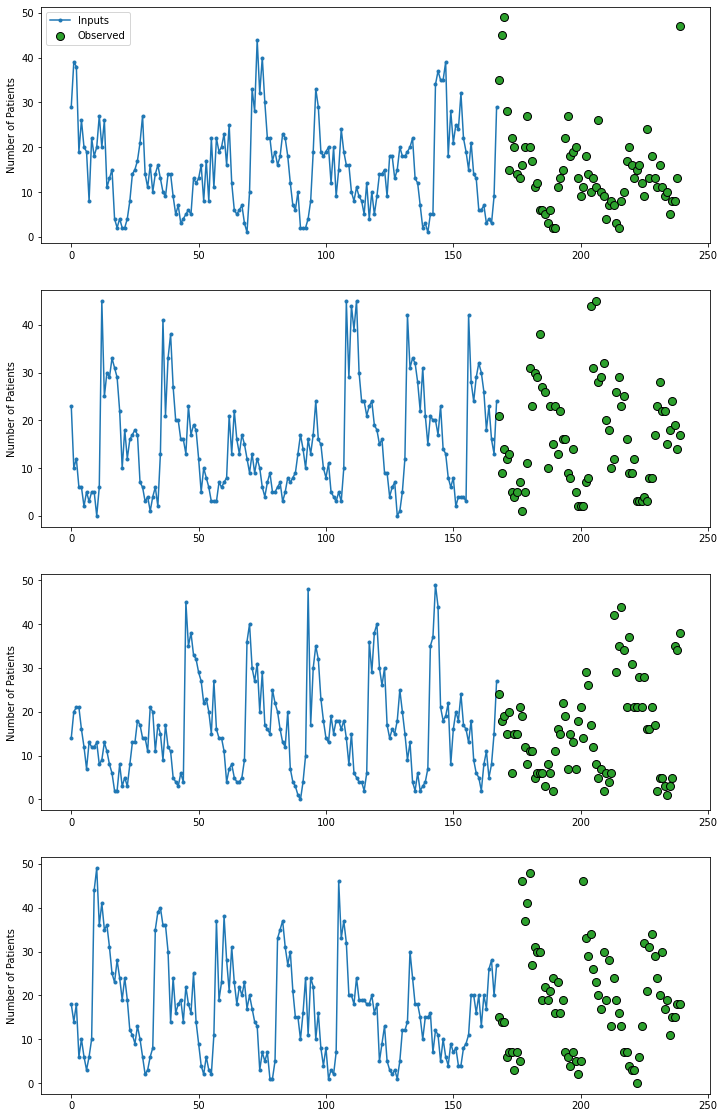

In [6]:
### Creating input/output windows of the time series
### OUT_STEPS: Number of hours in the future to predict
### input_width: Number of hours to use as an input for forecasting

OUT_STEPS = 72
multi_window = WindowGenerator(input_width=168,
                               label_width=OUT_STEPS,
                               train_df = train_df_1d, val_df=val_df_1d, 
                               test_df=test_df_1d,label_columns=['Number of Patients'])

multi_window.plot()
multi_window

In [7]:
### Defining Time Series LSTM model

multi_lstm_model = tf.keras.Sequential([
    
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS])
])

print("multi_lstm_model")
print('Input shape:', multi_window.example[0].shape)
print('Labels shape:', multi_window.example[1].shape)
print('Output shape:', multi_lstm_model(multi_window.example[0]).shape)

# ### fit model to the training data

# history = compile_and_fit(multi_lstm_model, multi_window)

# IPython.display.clear_output()

# For loading presaved model

multi_lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
	        optimizer=tf.keras.optimizers.Adam(),
	        metrics=[tf.keras.metrics.MeanAbsoluteError(),
	        tf.keras.metrics.MeanAbsolutePercentageError(),
	        tf.keras.losses.MeanSquaredError()])

checkpoint_name = 'best_model_numfeatures='+str(multi_window.example[0].shape[2])+'.ckpt'

print(checkpoint_name)

multi_lstm_model.load_weights(checkpoint_name)

multi_lstm_model
Input shape: (64, 168, 1)
Labels shape: (64, 72, 1)
Output shape: (64, 72)
best_model_numfeatures=1.ckpt


134/134 [==============================] - 6s 35ms/step - loss: 33.6590 - mean_absolute_error: 4.3568 - mean_absolute_percentage_error: 20028988.0000 - mean_squared_error: 33.5997


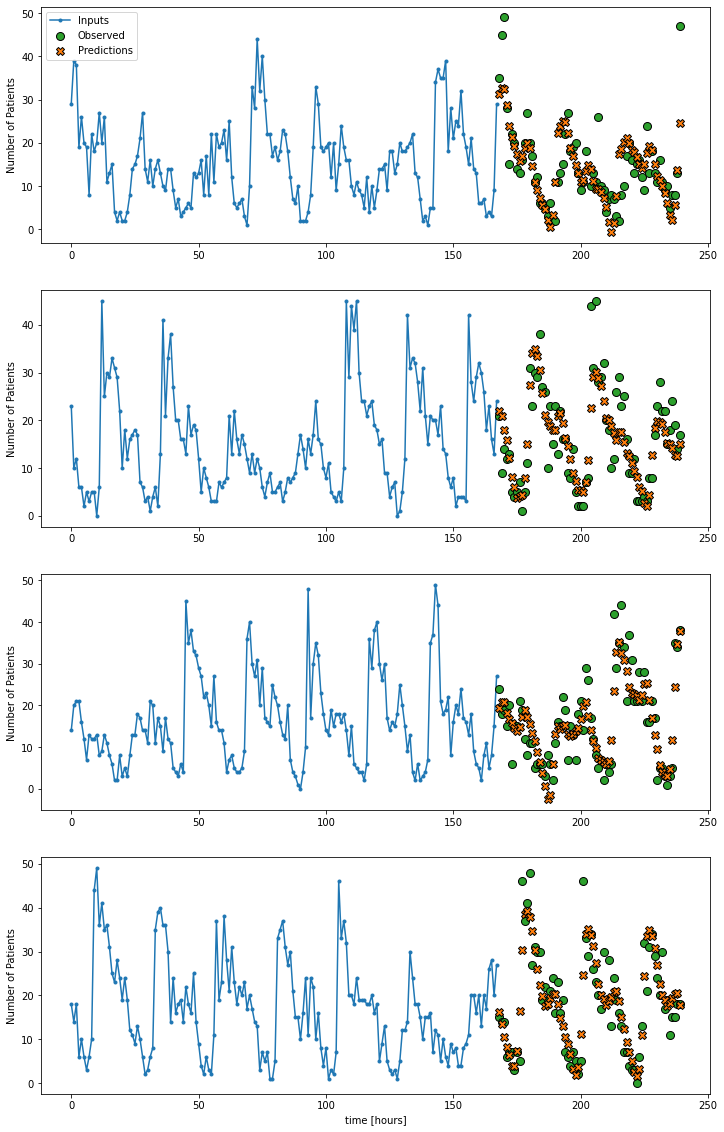

In [8]:
### Use the model to predict

multi_val_performance = {}
multi_performance = {}

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)
plt.rcParams['figure.figsize'] = [8, 12]
plt.xlabel('time [hours]')
plt.savefig('forecasts.png')

In [ ]:
### Plot the training curve

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Add temperature feature model

In [9]:
### Split testing and training data

train_df_2d = train_df[['Number of Patients','Maximum temperature (°C)']]
val_df_2d = val_df[['Number of Patients','Maximum temperature (°C)']]
test_df_2d = test_df[['Number of Patients','Maximum temperature (°C)']]

num_features = train_df_2d.shape[1]

Total window size: 240
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167]
Label indices: [168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 

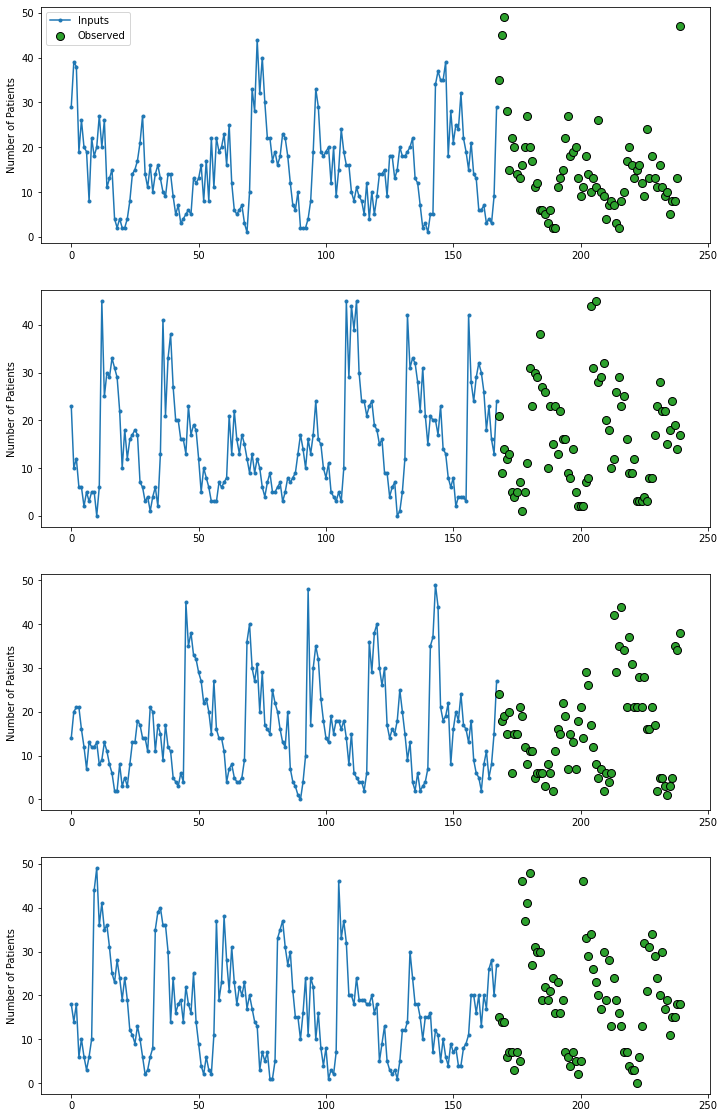

In [11]:
### Creating input/output windows of the time series
### OUT_STEPS: Number of hours in the future to predict
### input_width: Number of hours to use as an input for forecasting

OUT_STEPS = 72
multi_window_2d = WindowGenerator(input_width=168,
                               label_width=OUT_STEPS,
                               train_df = train_df_2d, val_df=val_df_2d, 
                               test_df=test_df_2d,label_columns=['Number of Patients'])

multi_window.plot()
multi_window

In [12]:
### Defining Time Series LSTM model

multi_lstm_model_2d = tf.keras.Sequential([
    
    # Shape [batch, time, features] => [batch, lstm_units].
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS])
])

print("multi_lstm_model_2d")
print('Input shape:', multi_window_2d.example[0].shape)
print('Labels shape:', multi_window_2d.example[1].shape)
print('Output shape:', multi_lstm_model_2d(multi_window_2d.example[0]).shape)

### fit model to the training data

# history = compile_and_fit(multi_lstm_model_2d, multi_window_2d)

# IPython.display.clear_output()

# For loading presaved model

multi_lstm_model_2d.compile(loss=tf.keras.losses.MeanSquaredError(),
	        optimizer=tf.keras.optimizers.Adam(),
	        metrics=[tf.keras.metrics.MeanAbsoluteError(),
	        tf.keras.metrics.MeanAbsolutePercentageError(),
	        tf.keras.losses.MeanSquaredError()])

checkpoint_name = 'best_model_numfeatures='+str(multi_window_2d.example[0].shape[2])+'.ckpt'

multi_lstm_model_2d.load_weights(checkpoint_name)

multi_lstm_model_2d
Input shape: (64, 168, 2)
Labels shape: (64, 72, 1)
Output shape: (64, 72)


In [ ]:
### Plot the training curve

plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

134/134 [==============================] - 5s 30ms/step - loss: 35.0877 - mean_absolute_error: 4.3885 - mean_absolute_percentage_error: 21285620.0000 - mean_squared_error: 35.0242


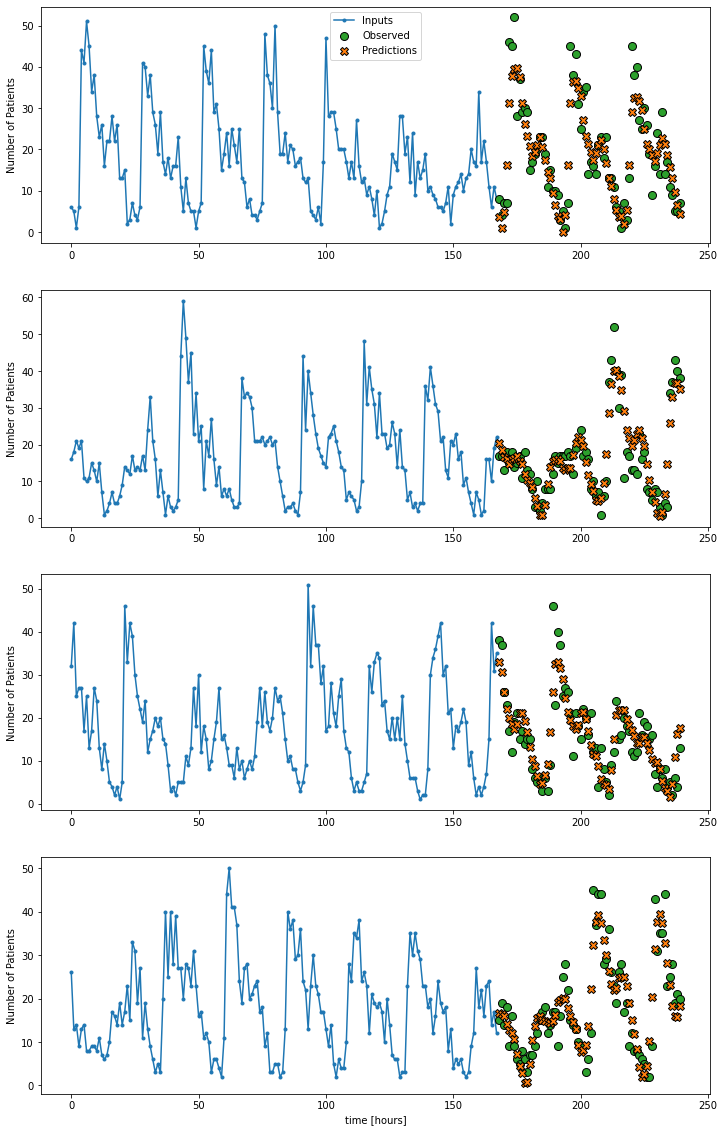

In [13]:
### Use the model to predict

multi_val_performance['LSTM_weather'] = multi_lstm_model_2d.evaluate(multi_window_2d.val)
multi_performance['LSTM_weather'] = multi_lstm_model_2d.evaluate(multi_window_2d.test, verbose=0)
multi_window_2d.plot(multi_lstm_model_2d)
plt.rcParams['figure.figsize'] = [8, 12]
plt.xlabel('time [hours]')
plt.savefig('forecasts.png')

# Results 

In [40]:
ypred = multi_lstm_model.predict(multi_window.test)
ypred_2d = multi_lstm_model_2d.predict(multi_window_2d.test)

2/2 [==============================] - 0s 25ms/step


In [34]:
ypred_lin = pd.read_csv('~/Downloads/forecasts07 (1).csv',index_col=0)

In [16]:
ypred_lin = np.pad(np.array(ypred_lin['Forecasts of arrivals']), (0,73))

In [37]:
ypred_lin[0:7224-24*7] .shape

(7056, 1)

In [42]:
ypred.flatten().shape

(613512,)

In [18]:
ypred_TBATS = np.loadtxt('TBATS.txt')

In [19]:
ypred_TBATS.shape

(7322,)

In [20]:
y = np.concatenate([y for x, y in multi_window.test], axis=0)
x = np.concatenate([x for x, y in multi_window.test], axis=0)

In [21]:
print(x.shape)
print(y.shape)

(99, 168, 1)
(99, 72, 1)


In [22]:
y = y[:,:,0]
x = x[:,:,0]

In [32]:
sum(abs(0.5*ypred.flatten()+0.5*ypred_lin[96:-73]-y.flatten()))/len(y.flatten())

4.911518035844309

In [33]:
sum(abs(ypred_lin[96:-73]-y.flatten()))/len(y.flatten())

6.6380827977989405

In [23]:
y.flatten().shape

(7128,)

In [ ]:
time_range = pd.date_range('2007-01-01T00:00:00.000Z', '2007-11-01T00:00:00.000Z', freq='H')
time_range = np.array([str(x.day_name()[:3])+ ' '+str(x.day)+'th '+str(x.month_name()[:3]) for x in time_range])

In [ ]:
input_step = 168
output_step = 72
n = time_range.shape[0]
input_times = np.array( [ time_range[i:i+input_step] for i in range(n-input_step-output_step+1) ]).reshape(n-input_step-output_step+1,input_step,1)[:,:,0]
label_times = np.array( [ time_range[i+input_step:i+input_step+output_step] for i in range(n-input_step-output_step+1) ]).reshape(n-input_step-output_step+1,output_step,1)[:,:,0]
ypred_lin = np.array( [ ypred_lin[i+input_step:i+input_step+output_step] for i in range(n-input_step-output_step+1) ]).reshape(n-input_step-output_step+1,output_step,1)[:,:,0]
ypred_TBATS = np.array( [ ypred_TBATS[i+input_step:i+input_step+output_step] for i in range(n-input_step-output_step+1) ]).reshape(n-input_step-output_step+1,output_step,1)[:,:,0]

In [ ]:
## MAPE
(np.fabs(ypred[y!=0]-y[y!=0])/y[y!=0]).mean()

In [ ]:
ypred.shape

In [ ]:
def get_day_label(date_range):
    n = len(np.unique(date_range))
    sub_range = date_range[np.where(date_range[:-1] != date_range[1:])[0]+1]
    indexes = np.where(date_range[:-1] != date_range[1:])[0]+1
    return indexes, sub_range

In [ ]:
sns.set_theme()
forecast_index = 1240
mpl.rcParams['figure.figsize'] = (21 , 29.7 )
fig, ax = plt.subplots(4,1)
sns.set(font_scale=1.5)
fontsz=17
i=0 
for forecast_index in [1000 , 2886 , 5000, 6976]:
    
    
    ax[i].plot(range(len(ypred[forecast_index,:])),ypred[forecast_index,:],label='LSTM')
    ax[i].plot(range(len(ypred[forecast_index,:])),ypred_2d[forecast_index,:],label='LSTM_weather')
    ax[i].plot(range(len(ypred_lin[forecast_index,:])),ypred_lin[forecast_index,:],label='Linear')
    ax[i].plot(range(len(ypred_lin[forecast_index,:])),ypred_TBATS[forecast_index,:],label='TBATS')
    ax[i].scatter(range(len(y[forecast_index,:])),y[forecast_index,:],edgecolors='k', label='Observed', c='#2ca02c', s=64)
    # plt.xticks(np.arange(0, output_step, 1))
    # ax.set_xticklabels(label_times[forecast_index,:],rotation=90)
    indexes, sub_range = get_day_label(label_times[forecast_index,:])
    ax[i].set_xticks(indexes)
    ax[i].set_xticklabels(sub_range,fontsize = fontsz)
    ax[i].set_ylabel('Number of Patients',fontsize = fontsz)

    if i==0:
        ax[i].legend()
    i+=1
    
plt.savefig('forecasts.png')

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

mpl.rcParams['figure.figsize'] = (8, 6)
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
plt.ylim([0,6])

In [ ]:
multi_performance